# Crop Spatial Raster Data with a Shapefile

## About spatial crop

Cropping/Clipping, is when you subset or make a dataset smaller, by removing all data outside of the crop area or spatial extent. In this case you have a large raster - but let's pretend that you only need to work with a smaller subset of the raster.

You can use the crop_image function to remove all of the data outside of your study area. This is useful as it:
1. Makes the data smaller and
2. Makes processing and plotting faster

In general when you can, it's often a good idea to crop your raster data!

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5)

# Get data and set work dir
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

## Open raster and vector layers

## Open vector layer

To begin your clip, open up a vector layer that contains the crop extent that you want to use to crop your data. To open a shapefile you use the gpd.read_file() function from geopandas.

## Read raster

In [2]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("data", "colorado-flood", "spatial",
                        "boulder-leehill-rd", "pre-flood", "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
with rio.open(dtm_path) as src:
    lidar_dtm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

with rio.open(dsm_path) as src:
    lidar_dsm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

# Create canopy height model (CHM)    
lidar_chm_im = lidar_dsm_im - lidar_dtm_im
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [3]:
aoi = os.path.join("data", "colorado-flood", "spatial",
                  "boulder-leehill-rd", "clip-extent.shp")

# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(aoi)

Next, view the CRS of both of your datasets. Remember that in order to perform any analysis with these 2 datasets together, they will need to be in the same CRS.

In [4]:
os.chdir("C:/Users/s1526/Dropbox/Python_Tutorials/Earth Data Analytics/Python/Intermediate/3. Raster/outputs")

chm_path = os.path.join("lidar_chm.tif")

lidar_chm = rio.open(chm_path)

In [5]:
print("crop extent crs: ", crop_extent.crs)
print("lidar crs: ", lidar_chm.crs)

crop extent crs:  epsg:32613
lidar crs:  EPSG:32613


Text(0.5, 1.0, 'Shapefile Crop Extent')

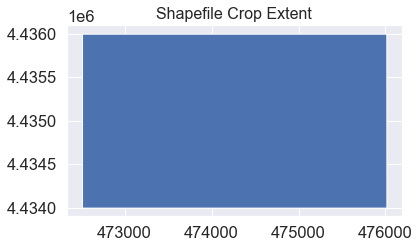

In [6]:
# Plot the crop boundary layer
# Note this is just an example so you can see what it looks like
fig, ax = plt.subplots(figsize=(6, 6))

crop_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
            fontsize=16)

Now that you have imported the shapefile. You can use the crop_image function from earthpy.spatial to crop the raster data using the vector shapefile.

c:\programdata\miniconda3\lib\site-packages\numpy\ma\core.py:1026: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


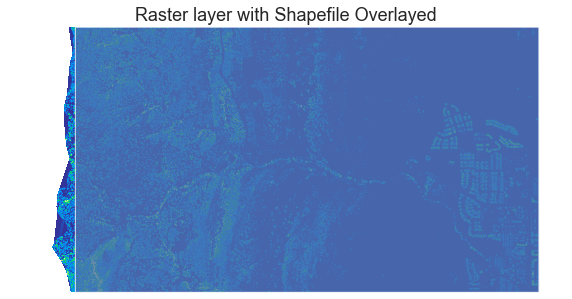

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ep.plot_bands(lidar_chm_im, cmap="terrain",
             extent=plotting_extent(lidar_chm),
             ax=ax,
             title="Raster layer with Shapefile Overlayed",
             cbar=False)

crop_extent.plot(ax=ax, alpha=.8)

ax.set_axis_off()

## Crop data using the crop_image function

If you want to crop the data you can use the crop_image function in earthpy.spatial. When you crop the data, you can then export it and share it with colleagues. or use it in another analysis. IMPORTANT: You do not need to read the data in before cropping! Cropping the data can be your first step.

To perform the crop you:
1. Create a connection to the raster dataset that you wish to crop
2. Open your shp as a geopandas object. This is what Earthpy needs to crop the data to the extent of your vector shapefile.
3. Crop the data using the crop_image() function.

Without Earthpy, you would have to perform this with a Geojson object. Geojson is a format that is worth becoming familiar with. It's a text, structured format that is used in many online application.

In [8]:
with rio.open(chm_path) as lidar_chm:
    lidar_chm_crop, lidar_chm_crop_meta = es.crop_image(lidar_chm, crop_extent)
    
lidar_chm_crop_affine = lidar_chm_crop_meta["transform"]

# Create spatial plotting extent from the cropped layer
lidar_chm_extent = plotting_extent(lidar_chm_crop[0], lidar_chm_crop_affine)

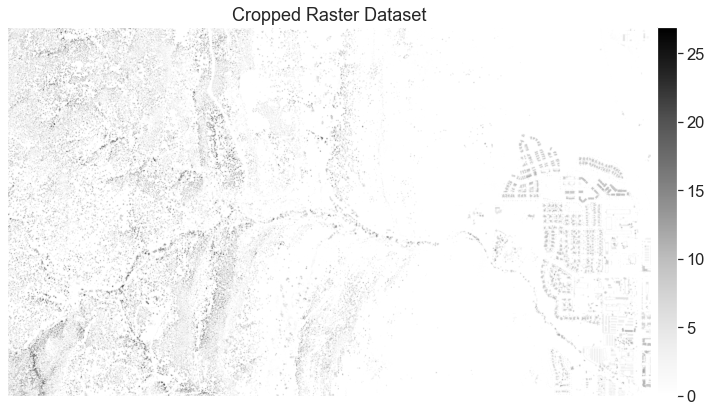

In [9]:
# Plot your data
ep.plot_bands(lidar_chm_crop[0],
             extent=lidar_chm_extent,
             cmap="Greys",
             title="Cropped Raster Dataset",
             scale=False)

plt.show()

## Export newly cropped raster

Once you have cropped your data, you may want to export it. In the subtract raster lesson you exported a raster that had the same shape and transform info as the parent raster. However in this case, you have cropped your data. You will have to update several things to ensure your data export properly:
1. The width and height of the raster. You can get this info from the SHAPE of the cropped numpy array and
2. The transformation info of the affine object. The crop_image() function provides this inside the metadata object it returns!
3. Finally you may want to update the nodata value.

In this case you don't have any nodata values in your raster. However you may have them in a future raster!

In [11]:
# Update with the new cropped affine info and the new width and height
lidar_chm.meta.update({"transform": lidar_chm_crop_affine,
                      "height": lidar_chm_crop.shape[1],
                      "width": lidar_chm_crop.shape[2],
                      "nodata": -999.99})

lidar_chm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999.99,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

In [14]:
os.getcwd()

'C:\\Users\\s1526\\Dropbox\\Python_Tutorials\\Earth Data Analytics\\Python\\Intermediate\\3. Raster\\outputs'

In [15]:
# Write data
path_out = os.path.join("lidar_chm_cropped.tif")

with rio.open(path_out, "w", **lidar_chm.meta) as ff:
    ff.write(lidar_chm_crop[0], 1)